This notebook is the computation work to plot out the shortest route between cities under the "Traveling Salesman" project guidelines. Because of the trial and error approach anticipated, I've elected to use jupyter notebooks, though I understand writing script in C or even a real .py file may have been faster.
============

In [1]:
import numpy as np
from numba import jit
import time
import matplotlib.pyplot as plt

Let's first focus on setting up the calculations:

In [2]:
@jit(nopython=True)
def distance(lat_i, long_i, lat_f, long_f):
    R = 6371.0 # km
    dlat = lat_f - lat_i
    dlong = long_f - long_i
    A = ( np.sin(dlat / 2) )**2 + np.cos(lat_i)*np.cos(lat_f)*( np.sin(dlong / 2) )**2
    c = 2*np.arctan2( np.sqrt(A), np.sqrt(1 - A) )
    return R * c

In [3]:
@jit(nopython=True)
def total_distance(tour, lats, longs):
    """Calculate total distance of a tour"""
    n = len(tour)
    dist = 0.0
    for i in range(n):
        j = (i + 1) % n
        dist += distance(lats[tour[i]], longs[tour[i]], 
                        lats[tour[j]], longs[tour[j]])
    return dist

In [4]:
@jit(nopython=True)
def two_opt_swap(tour, i, j):
    """Perform a 2-opt swap: reverse the segment between i and j"""
    new_tour = tour.copy()
    new_tour[i:j+1] = new_tour[i:j+1][::-1]
    return new_tour

In [5]:
@jit(nopython=True)
def delta_distance_2opt(tour, lats, longs, i, j):
    """Calculate change in distance from 2-opt swap without full recalculation"""
    n = len(tour)
    # Get the four edges that change
    i_prev = (i - 1) % n
    j_next = (j + 1) % n
    
    # Old edges: (i_prev, i) and (j, j_next)
    old_dist = (distance(lats[tour[i_prev]], longs[tour[i_prev]], 
                        lats[tour[i]], longs[tour[i]]) +
                distance(lats[tour[j]], longs[tour[j]], 
                        lats[tour[j_next]], longs[tour[j_next]]))
    
    # New edges: (i_prev, j) and (i, j_next)
    new_dist = (distance(lats[tour[i_prev]], longs[tour[i_prev]], 
                        lats[tour[j]], longs[tour[j]]) +
                distance(lats[tour[i]], longs[tour[i]], 
                        lats[tour[j_next]], longs[tour[j_next]]))
    
    return new_dist - old_dist


In [6]:
def validate_delta_calculation(tour, lats, longs, n_tests=100):
    """
    Validate that delta_distance_2opt correctly computes distance changes
    """
    print("Validating delta calculation...")
    n = len(tour)
    max_error = 0.0
    
    for _ in range(n_tests):
        i = np.random.randint(0, n - 2)
        j = np.random.randint(i + 2, n)
        
        # Method 1: Using delta calculation
        delta = delta_distance_2opt(tour, lats, longs, i, j)
        
        # Method 2: Full recalculation
        old_dist = total_distance(tour, lats, longs)
        new_tour = two_opt_swap(tour, i, j)
        new_dist = total_distance(new_tour, lats, longs)
        actual_delta = new_dist - old_dist
        
        error = abs(delta - actual_delta)
        max_error = max(max_error, error)
        
        if error > 0.01:  # Alert if error is significant
            print(f"Warning: Error = {error:.6f} km at i={i}, j={j}")
    
    print(f"Validation complete. Max error: {max_error:.6f} km")
    if max_error < 0.001:
        print("✓ Delta calculation is correct!")
    else:
        print("✗ Delta calculation has issues!")
    
    return max_error

In [7]:
@jit(nopython=True)
def metropolis(current_tour, current_dist, lats, longs, T, n_iter):
    """
    Run Metropolis algorithm at fixed temperature
    
    Parameters:
    -----------
    current_tour : current tour configuration
    current_dist : distance of current tour
    lats, longs : arrays of city coordinates (in radians)
    T : temperature
    n_iter : number of iterations to run
    
    Returns:
    --------
    current_tour : updated tour
    current_dist : updated distance
    best_tour : best tour found during this run
    best_dist : best distance found during this run
    """
    n = len(current_tour)
    
    # Track best solution at this temperature
    best_tour = current_tour.copy()
    best_dist = current_dist
    
    for _ in range(n_iter):
        # Generate random 2-opt swap
        i = np.random.randint(1, n-1)
        j = np.random.randint(i+1, n)
        
        # Choose segment length - favor smaller segments
        # Using exponential distribution to bias toward local swaps
        #max_segment = min(n // 2, 50)  # Cap at 50 cities or half the tour
        #segment_length = int(np.random.exponential(scale=5)) + 2
        #segment_length = min(segment_length, max_segment)
        #segment_length = max(segment_length, 2)  # Ensure at least 2
        
        # Make sure j doesn't exceed array bounds
        #j = min(i + segment_length, n - 1)
        
        # Ensure i < j for the swap
        if i > j:
            i, j = j, i
        
        # Skip if segment is too small
        if j - i < 2:
            continue
        
        # Calculate change in distance
        delta = delta_distance_2opt(current_tour, lats, longs, i, j)
        
        # Metropolis criterion
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            # Accept the move
            current_tour = two_opt_swap(current_tour, i, j)
            current_dist += delta
            
            # Update best solution
            if current_dist < best_dist:
                best_tour = current_tour.copy()
                best_dist = current_dist
    
    return current_tour, current_dist, best_tour, best_dist

Ok, now, let's make sure everything is working before proceeding.

In [8]:
# Load data, skip header, read only longitude and latitude columns
data = np.loadtxt("cities2k.dat", skiprows=1, usecols=(0, 1))
lats = np.radians(data[:, 1])
longs = np.radians(data[:, 0])
tour = np.arange(len(lats))
validate_delta_calculation(tour, lats, longs)
print("--------------------")

n = len(lats)
T=500.0
nsweeps=10000
      
# Initialize with random tour
current_tour = np.arange(n)
np.random.shuffle(current_tour)
current_dist = total_distance(current_tour, lats, longs)
initial_dist = current_dist

print(f"Initial distance: {initial_dist:.2f} km")
print(f"Running Metropolis (T={T}, nsweeps={nsweeps})...")
    
# Run Metropolis
current_tour, current_dist, best_tour, best_dist = metropolis(current_tour, current_dist, lats, longs, T, nsweeps)
    
print(f"Final distance: {best_dist:.2f} km")
print(f"Improvement: {initial_dist - best_dist:.2f} km ({100*(initial_dist-best_dist)/initial_dist:.1f}%)")

Validating delta calculation...
Validation complete. Max error: 0.000000 km
✓ Delta calculation is correct!
--------------------
Initial distance: 11887254.33 km
Running Metropolis (T=500.0, nsweeps=10000)...
Final distance: 6282205.92 km
Improvement: 5605048.41 km (47.2%)


Great! Now let's run it through the simulated annealing process.
=======

In [9]:
@jit(nopython=True)
def simulated_annealing(lats, longs, T_init=10000, T_min=0.1, 
                       alpha=0.9995, nsweeps=1000):
    """
    Simulated annealing for TSP using cooling schedule
    
    Parameters:
    -----------
    lats, longs : arrays of city coordinates (in radians)
    T_init : initial temperature
    T_min : minimum temperature (stopping criterion)
    alpha : cooling rate (T_new = alpha * T_old)
    nsweeps : number of Metropolis iterations per temperature
    
    Returns:
    --------
    best_tour : best tour found
    best_dist : distance of best tour
    T_data : data set of temperature values
    distance_data : data set of distance values corresponding to each T
    """
    n = len(lats)
    
    # Initialize with random tour
    current_tour = np.arange(n)
    np.random.shuffle(current_tour)
    current_dist = total_distance(current_tour, lats, longs)
    initial_dist = current_dist
    
    # Best solution tracking
    best_tour = current_tour.copy()
    best_dist = current_dist
    
    T = T_init
    temp_iteration = 0

    # Track data for plotting
    T_data = [T]
    distance_data = [current_dist]
    
    while T > T_min:
        # Run Metropolis at current temperature
        current_tour, current_dist, temp_best_tour, temp_best_dist = \
            metropolis(current_tour, current_dist, lats, longs, T, nsweeps)
        
        # Update global best
        if temp_best_dist < best_dist:
            best_tour = temp_best_tour.copy()
            best_dist = temp_best_dist
        
        # Cool down
        T *= alpha
        temp_iteration += 1

        # Append data to sets
        T_data.append(T)
        distance_data.append(current_dist)
        
        # Progress indicator every 50 temperature steps
        #if temp_iteration % 50 == 0:
        #    print(f"Temperature iteration {temp_iteration}, T={T:.2f}, Best dist={best_dist:.2f} km")
    
    return best_tour, initial_dist, best_dist, T_data, distance_data

In [10]:
def simulated_annealing_verbose(lats, longs, T_init=10000, T_min=0.1, 
                                alpha=0.9995, nsweeps=1000, verbose=True):
    """
    Wrapper for simulated annealing with progress printing
    """
    n = len(lats)
    
    # Initialize with random tour
    current_tour = np.arange(n)
    np.random.shuffle(current_tour)
    current_dist = total_distance(current_tour, lats, longs)
    initial_dist = current_dist
    
    # Best solution tracking
    best_tour = current_tour.copy()
    best_dist = current_dist
    
    T = T_init
    temp_iteration = 0

    # Track data for plotting
    T_data = [T]
    distance_data = [current_dist]
    
    if verbose:
        print(f"Initial distance: {current_dist:.2f} km")
    
    while T > T_min:
        # Run Metropolis at current temperature
        current_tour, current_dist, temp_best_tour, temp_best_dist = \
            metropolis(current_tour, current_dist, lats, longs, T, nsweeps)
        
        # Update global best
        if temp_best_dist < best_dist:
            best_tour = temp_best_tour.copy()
            best_dist = temp_best_dist
            if verbose:
                print(f"  New best found: {best_dist:.2f} km at T={T:.2f}")
        
        # Cool down
        T *= alpha
        temp_iteration += 1

        # Append data to sets
        T_data.append(T)
        distance_data.append(current_dist)
        
        # Progress indicator every 50 temperature steps
        if verbose and temp_iteration % 50 == 0:
            print(f"Temperature iteration {temp_iteration}, T={T:.2f}, Current={current_dist:.2f}, Best={best_dist:.2f} km")
    
    if verbose:
        print(f"\nFinal: Best distance = {best_dist:.2f} km")
    
    return best_tour, initial_dist, best_dist, T_data, distance_data

In [11]:
def validate_tour(tour, lats, longs):
    """
    Validate that a tour is a valid TSP solution
    """
    print("\n=== Tour Validation ===")
    n = len(lats)
    
    # Check 1: All cities appear exactly once
    unique_cities = len(np.unique(tour))
    print(f"Number of unique cities in tour: {unique_cities}/{n}")
    if unique_cities != n:
        print("✗ ERROR: Tour does not contain all cities exactly once!")
        missing = set(range(n)) - set(tour)
        duplicates = [x for x in tour if list(tour).count(x) > 1]
        if missing:
            print(f"  Missing cities: {missing}")
        if duplicates:
            print(f"  Duplicate cities: {set(duplicates)}")
        return False
    
    # Check 2: Tour length matches number of cities
    if len(tour) != n:
        print(f"✗ ERROR: Tour length {len(tour)} != number of cities {n}")
        return False
    
    # Check 3: Calculate and display distance
    dist = total_distance(tour, lats, longs)
    print(f"Total tour distance: {dist:.2f} km")
    
    # Check 4: Show first few and last few cities in tour
    print(f"Tour starts: {tour[:5]}")
    print(f"Tour ends: {tour[-5:]}")
    
    print("✓ Tour is valid!")
    return True

In [12]:
%%time

# Load data, skip header, read only longitude and latitude columns
data = np.loadtxt("cities23.dat", skiprows=1, usecols=(0, 1))
lats = np.radians(data[:, 1])
longs = np.radians(data[:, 0])

best_tour23, initial_dist23, best_dist23, T23, D23 = simulated_annealing(lats, longs, T_init=100000.0, T_min=0.1, 
                       alpha=0.995, nsweeps=10000)
print(f"Initial distance: {initial_dist23:.2f} km")
print(f"Best distance: {best_dist23:.2f} km")
print(f"Improvement: {initial_dist23 - best_dist23:.2f} km ({100*(initial_dist23-best_dist23)/initial_dist23:.1f}%)")
validate_tour(best_tour23, lats, longs)

Initial distance: 45795.29 km
Best distance: 13404.55 km
Improvement: 32390.74 km (70.7%)

=== Tour Validation ===
Number of unique cities in tour: 23/23
Total tour distance: 13404.55 km
Tour starts: [12  1 16 10  8]
Tour ends: [11 18 19  2  4]
✓ Tour is valid!
CPU times: user 10.4 s, sys: 25.8 ms, total: 10.5 s
Wall time: 10.7 s


True

In [13]:
%%time

# Load data, skip header, read only longitude and latitude columns
data = np.loadtxt("cities23.dat", skiprows=1, usecols=(0, 1))
lats = np.radians(data[:, 1])
longs = np.radians(data[:, 0])

best_tour23, initial_dist23, best_dist23, T23, D23 = simulated_annealing_verbose(lats, longs, T_init=10000, T_min=0.1, 
                                alpha=0.9995, nsweeps=1000, verbose=False)
print(f"Initial distance: {initial_dist23:.2f} km")
print(f"Best distance: {best_dist23:.2f} km")
print(f"Improvement: {initial_dist23 - best_dist23:.2f} km ({100*(initial_dist23-best_dist23)/initial_dist23:.1f}%)")

Initial distance: 42281.97 km
Best distance: 13404.55 km
Improvement: 28877.42 km (68.3%)
CPU times: user 8.15 s, sys: 8.07 ms, total: 8.16 s
Wall time: 8.34 s


In [14]:
%%time

# Load data, skip header, read only longitude and latitude columns
data = np.loadtxt("cities150.dat", skiprows=1, usecols=(0, 1))
lats = np.radians(data[:, 1])
longs = np.radians(data[:, 0])

best_tour150, initial_dist150, best_dist150, T150, D150 = simulated_annealing_verbose(lats, longs, T_init=10000, T_min=0.1, 
                                alpha=0.9995, nsweeps=1000, verbose=False)
print(f"Initial distance: {initial_dist150:.2f} km")
print(f"Best distance: {best_dist150:.2f} km")
print(f"Improvement: {initial_dist150 - best_dist150:.2f} km ({100*(initial_dist150-best_dist150)/initial_dist150:.1f}%)")
validate_tour(best_tour150, lats, longs)

Initial distance: 327790.70 km
Best distance: 48627.37 km
Improvement: 279163.34 km (85.2%)

=== Tour Validation ===
Number of unique cities in tour: 150/150
Total tour distance: 48627.37 km
Tour starts: [52 23 69 85 61]
Tour ends: [30 44 76 22 41]
✓ Tour is valid!
CPU times: user 9.14 s, sys: 2.61 ms, total: 9.15 s
Wall time: 9.38 s


True

In [15]:
%%time

# Load data, skip header, read only longitude and latitude columns
data = np.loadtxt("cities1k.dat", skiprows=1, usecols=(0, 1))
lats = np.radians(data[:, 1])
longs = np.radians(data[:, 0])

best_tour1k, initial_dist1k, best_dist1k, T1k, D1k = simulated_annealing(lats, longs, T_init=100000.0, T_min=0.1, 
                       alpha=0.995, nsweeps=10000)
print(f"Initial distance: {initial_dist1k:.2f} km")
print(f"Best distance: {best_dist1k:.2f} km")
print(f"Improvement: {initial_dist1k - best_dist1k:.2f} km ({100*(initial_dist1k-best_dist1k)/initial_dist1k:.1f}%)")

Initial distance: 2781799.58 km
Best distance: 102989.05 km
Improvement: 2678810.53 km (96.3%)
CPU times: user 14.7 s, sys: 6.17 ms, total: 14.7 s
Wall time: 15.1 s


In [16]:
%%time

# Load data, skip header, read only longitude and latitude columns
data = np.loadtxt("cities2k.dat", skiprows=1, usecols=(0, 1))
lats = np.radians(data[:, 1])
longs = np.radians(data[:, 0])

best_tour2k, initial_dist2k, best_dist2k, T2k, D2k = simulated_annealing(lats, longs, T_init=100000.0, T_min=0.1, 
                       alpha=0.995, nsweeps=10000)
print(f"Initial distance: {initial_dist2k:.2f} km")
print(f"Best distance: {best_dist2k:.2f} km")
print(f"Improvement: {initial_dist2k - best_dist2k:.2f} km ({100*(initial_dist2k-best_dist2k)/initial_dist2k:.1f}%)")

Initial distance: 12040267.00 km
Best distance: 312940.95 km
Improvement: 11727326.05 km (97.4%)
CPU times: user 17.8 s, sys: 2.21 ms, total: 17.8 s
Wall time: 18.2 s


These all finished in around the same time, even after adding on many more cities, which is suspicious. Let's plot and see what the route looks like.
===========

In [17]:
def save_best_tours(input_filename, output_filename, best_tour):
    """Save cities in optimized route order to new file"""
    
    # Read all lines from original file
    with open(input_filename, 'r') as file:
        lines = file.readlines()
    
    # Header is first line
    header = lines[0]
    
    # Data lines (skip header)
    data_lines = lines[1:]
    
    # Write reordered file
    with open(output_filename, 'w') as file:
        # Write header
        file.write(header)
        
        # Write cities in route order
        for i in best_tour:
            file.write(data_lines[i])

In [18]:
save_best_tours("cities23.dat", "cities23_BEST.dat", best_tour23)
save_best_tours("cities150.dat", "cities150_BEST.dat", best_tour150)
save_best_tours("cities1k.dat", "cities1k_BEST.dat", best_tour1k)
save_best_tours("cities2k.dat", "cities2k_BEST.dat", best_tour2k)

Let's also look at the annealing schedule:
=====

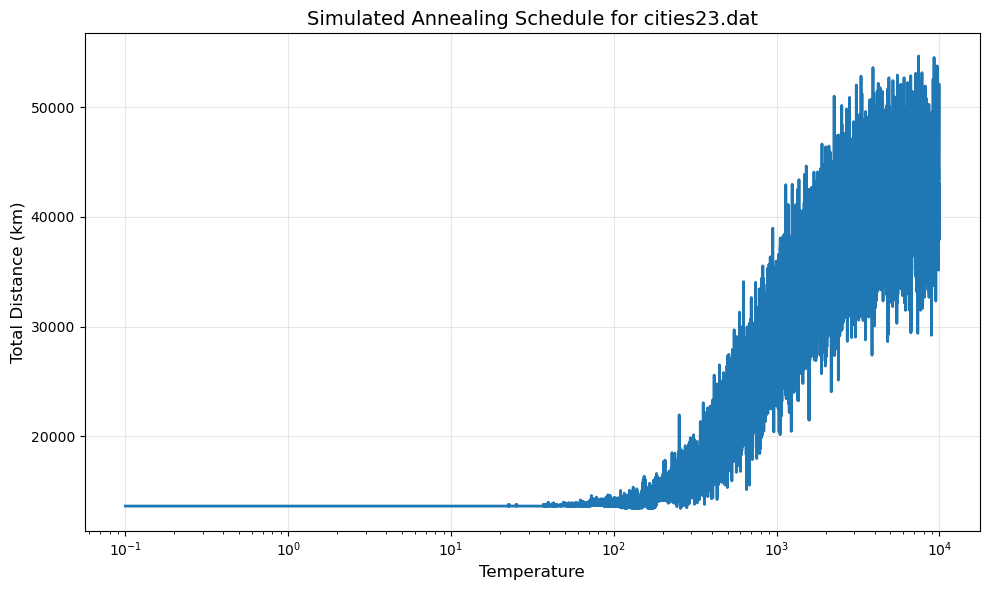

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(T23, D23, '-', linewidth=2)
plt.xlabel('Temperature', fontsize=12)
plt.xscale("log")
plt.ylabel('Total Distance (km)', fontsize=12)
plt.title('Simulated Annealing Schedule for cities23.dat', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Schedule23.png', dpi=300)

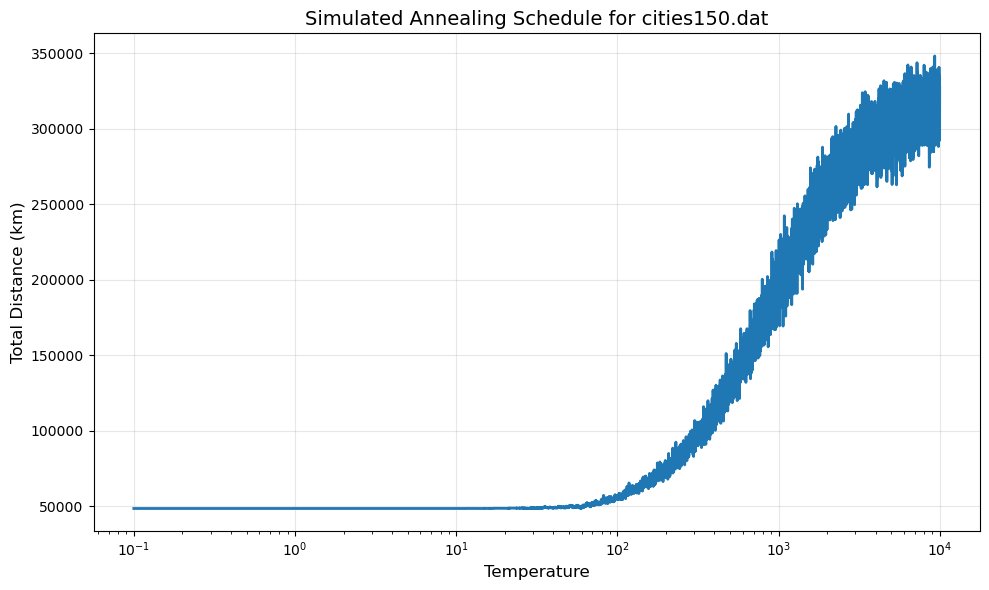

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(T150, D150, '-', linewidth=2)
plt.xlabel('Temperature', fontsize=12)
plt.xscale("log")
plt.ylabel('Total Distance (km)', fontsize=12)
plt.title('Simulated Annealing Schedule for cities150.dat', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Schedule150.png', dpi=300)

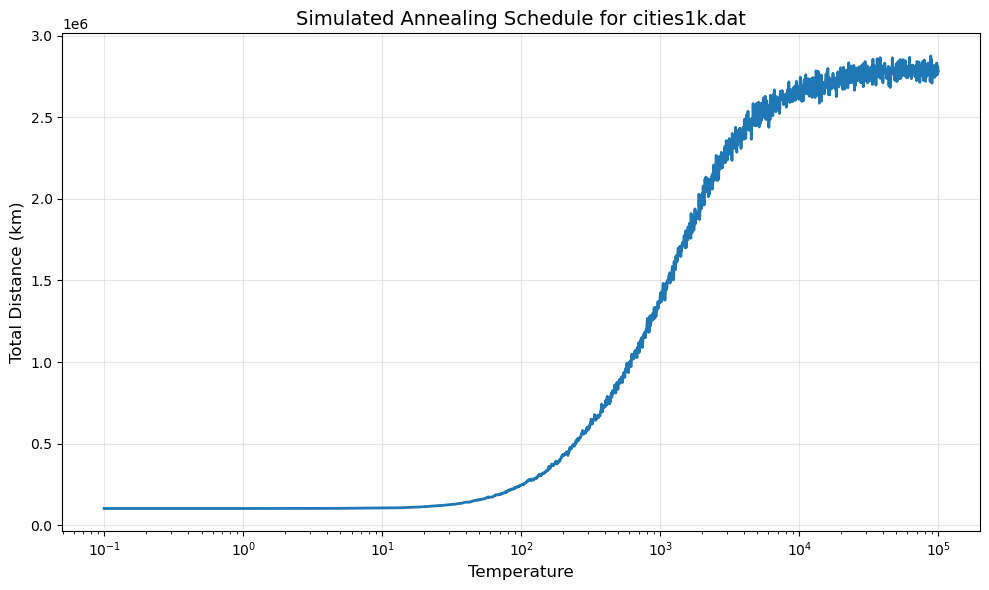

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(T1k, D1k, '-', linewidth=2)
plt.xlabel('Temperature', fontsize=12)
plt.xscale("log")
plt.ylabel('Total Distance (km)', fontsize=12)
plt.title('Simulated Annealing Schedule for cities1k.dat', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Schedule1k.png', dpi=300)

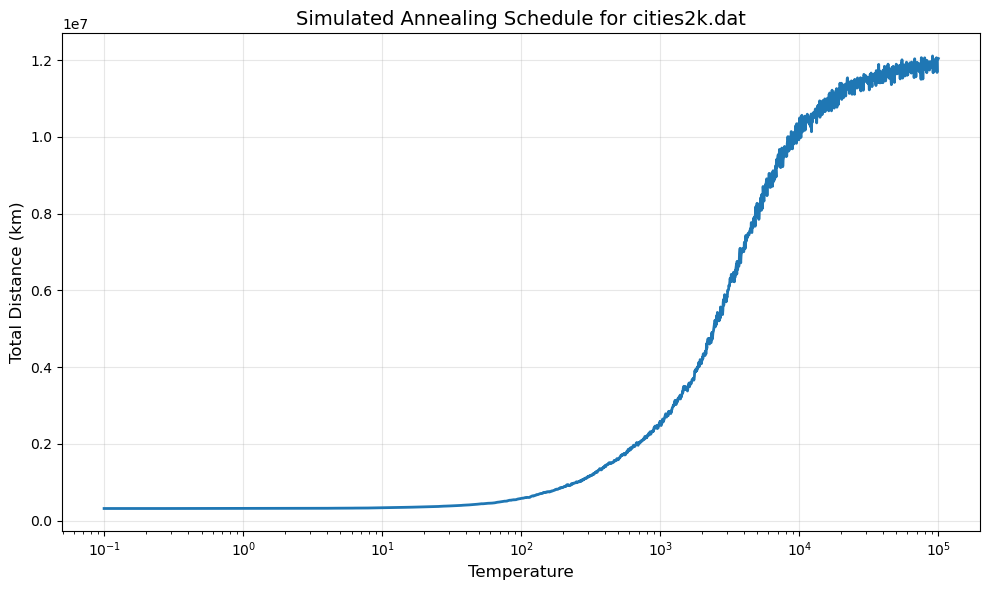

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(T2k, D2k, '-', linewidth=2)
plt.xlabel('Temperature', fontsize=12)
plt.xscale("log")
plt.ylabel('Total Distance (km)', fontsize=12)
plt.title('Simulated Annealing Schedule for cities2k.dat', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Schedule2k.png', dpi=300)